In [0]:
# Data
import numpy as np
import pandas as pd
import os
import csv
import xml.etree.ElementTree as ET
import scipy

# Framework
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard

# Imaging
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

In [2]:
from zipfile import ZipFile
file_name = 'blood-cells.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9724094846229529774, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12119529217332194611
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10072005198553109052
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3994985889
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14009977942544536324
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:

# Dicts for classifiers
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

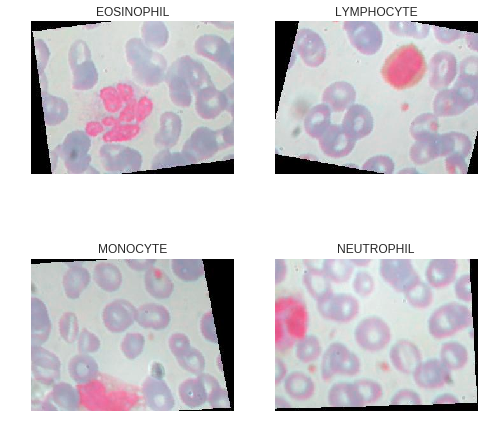

In [6]:
def plotImage(img_dir):
    img = cv2.imread(img_dir)
    plt.imshow(img)


# Demo different cell types
plt.figure(figsize=(8,8))

plt.subplot(221)
image_name = 'blood-cells/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.title('EOSINOPHIL')
plt.axis('off')
plotImage(image_name)

plt.subplot(222)
image_name = 'blood-cells/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.title('LYMPHOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(223)
image_name = 'blood-cells/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.title('MONOCYTE')
plt.axis('off')
plotImage(image_name)

plt.subplot(224)
image_name = 'blood-cells/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('NEUTROPHIL')
plt.axis('off')
plotImage(image_name)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


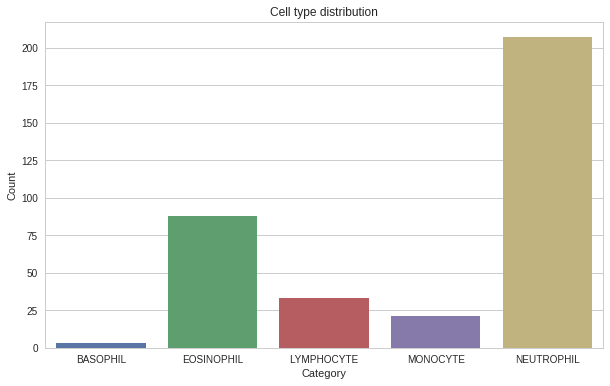

In [7]:
# Data distribution

df = pd.read_csv('blood-cells/dataset2-master/labels.csv')
df = df[['Image','Category']].dropna()
df1 = df[~df.Category.str.contains(",")]
x = df1.groupby('Category').count()

sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x = x.index, y = x['Image'])
ax.set(ylabel = 'Count', title = 'Cell type distribution')

plt.show()

In [9]:
# dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE', 5:'BASOPHIL'}
# dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

from tqdm import tqdm
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical


def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
                
                
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                
                if img_file is not None:
                    img_file = resize(img_file, (60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('blood-cells/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('blood-cells/dataset2-master/images/TEST/')


# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)


# label1 is Basophil vs Eosinophil vs Lymphocyte vs Monocyte vs Neutrophil
# Label2 is Mononuclear (Basophil + Lymphocyte + Monocyte) vs Polynuclear (Neutrophil + Eosinophil).

print("\nWe don't really care about basophil anyway.\n")
print(dict_characters)
print(dict_characters2)

  0%|          | 0/2499 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 620/620 [00:03<00:00, 187.93it/s]



We don't really care about basophil anyway.

{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE', 5: 'BASOPHIL'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [10]:
print("X_train:", X_train.size, "X_train_label", y_train.size)
print("X_train:", X_train.size, "X_train_label", y_trainHot.T.shape)


X_train: 143380800 X_train_label 9957
X_train: 143380800 X_train_label (5, 9957)


80.0


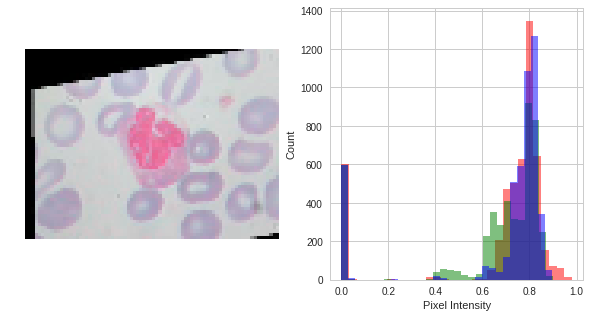

In [12]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);


plotHistogram(X_train[1])
print(X_train[1].size/3/60)

In [0]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
# sess = tf.Session(config = tf.ConfigProto(gpu_options=gpu_options))

# import time

# dense_layers = [1,2]
# layer_sizes = [32,64,128]
# conv_layers = [1,2,3]

# def build_CNN(x_train, x_label, y_test, y_label, batch_size = 128, epoch = 10):
#     num_category = len(x_label)
#     image_shape = x_train[0].shape
    
    
#     tensorborad = TensorBoard(log_dir='logs/{}'.format("testing"))

#     model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=image_shape))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    
#     model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    
#     model.add(Dense(128))
#     model.add(Activation('relu'))

#     model.add(Dropout(0.5))
#     # model.add(Dense(64))
#     # model.add(Activation('relu'))

#     model.add(Dense(num_category))
#     model.add(Activation('softmax'))



#     model.compile(loss='categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

# #                 model.fit(x_train, x_label, batch_size=32, epochs = epoch, validation_split=0.3, callbacks=[tensorborad])


#     datagen = ImageDataGenerator(
#                 featurewise_center=False,  # set input mean to 0 over the dataset
#                 samplewise_center=False,  # set each sample mean to 0
#                 featurewise_std_normalization=False,  # divide inputs by std of the dataset
#                 samplewise_std_normalization=False,  # divide each input by its std
#                 zca_whitening=False,  # apply ZCA whitening
#                 rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#                 width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#                 height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#                 horizontal_flip=True,  # randomly flip images
#                 vertical_flip=False) 
#     print(model.summary)

#     model.fit_generator(x_train, x_label,
#                         epochs=epoch, 
#                         validation_data = [y_test, y_label],
#                         callbacks = [tensorborad])

# #     print(model.summary)
                
# ##########################################################################################
# # Command for calling tensorboard: 
# #tensorboard --logdir=logs/ --host localhost --port 8088
# ##########################################################################################

In [29]:
import time
num_category = len(y_trainHot[0])
image_shape = X_train[0].shape
print(image_shape)

NAME = "logs/{}-{}".format("testing", int(time.time()))

tensorboard = TensorBoard(log_dir=NAME)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=image_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors


model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation('relu'))

model.add(Dense(num_category))
model.add(Activation('softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#                 model.fit(x_train, x_label, batch_size=32, epochs = epoch, validation_split=0.3, callbacks=[tensorborad])


datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False) 

history = model.fit_generator(datagen.flow(X_train, y_trainHot, batch_size=32),  steps_per_epoch=len(X_train) / 32, epochs= 30)
print(model.summary)

(60, 80, 3)
Epoch 1/30
312/312 [==============================] - 18s 56ms/step - loss: 1.4462 - acc: 0.2545
Epoch 2/30
312/312 [==============================] - 18s 58ms/step - loss: 1.3922 - acc: 0.2673
Epoch 3/30
312/312 [==============================] - 18s 58ms/step - loss: 1.3208 - acc: 0.3453
Epoch 4/30
312/312 [==============================] - 18s 57ms/step - loss: 1.2453 - acc: 0.4140
Epoch 5/30
312/312 [==============================] - 18s 58ms/step - loss: 1.1795 - acc: 0.4496
Epoch 6/30
312/312 [==============================] - 18s 58ms/step - loss: 1.1247 - acc: 0.4785
Epoch 7/30
312/312 [==============================] - 18s 58ms/step - loss: 1.0914 - acc: 0.4946
Epoch 8/30
312/312 [==============================] - 18s 57ms/step - loss: 1.0970 - acc: 0.4972
Epoch 9/30
312/312 [==============================] - 18s 58ms/step - loss: 1.0656 - acc: 0.5102
Epoch 10/30
312/312 [==============================] - 18s 58ms/step - loss: 1.2197 - acc: 0.4044
Epoch 11/30
312/3

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
activation_28 (Activation)   (None, 58, 78, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 29, 39, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 27, 37, 64)        18496     
_________________________________________________________________
activation_29 (Activation)   (None, 27, 37, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 18, 64)        0         
__________

In [31]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_testHot)
print("Validation loss", validation_loss)
print("Validation accuracy:",validation_accuracy)


2487/2487 [==============================] - 1s 313us/sample - loss: 0.4367 - acc: 0.8625
Validation loss 0.4367398364408744
Validation accuracy: 0.86248493


In [0]:
# model.save('my_model.h5')
# model = load_model('my_model.h5')
